## <span style="color:turquoise"> Exercise 08: Variational Monte Carlo with Simulated Annealing </span>

The variational principle in Quantum Mechanics states that the expectation value of the Hamiltonian over a (good) trial quantum state has the ground state energy $E_0$ as lower bound:

$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} \ge E_0 =
\frac{\langle \Psi_0| {\hat H} | \Psi_0 \rangle}
{\langle \Psi_0 | \Psi_0 \rangle}
$$

During this exercise you will variationally optimize the ground state of a single quantum particle in a one dimensional (1D) space confined by the following external potential:
$$
V(x) = x^4 - \frac{5}{2}x^2
$$

This 1D quantum model is not analytically solvable and should be attacked by numerical methods. In order to obtain an approximate wave function for the ground state, the Variational Monte Carlo method uses a trial wave function, parametrized by a set of variational parameters. An approximate model for the ground state wave function is the following trial wave function:
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}}+
                               e^{-\frac{(x+\mu)^2}{2\sigma^2}}
$$

$\Psi_T^{\sigma,\mu}(x)$ depends on <span style="color:red">two variational parameters:</span> $\sigma$ and $\mu$.

### <span style="color:turquoise"> Method </span>

In order to find the optimal values of $\mu$ and $\sigma$ we will perform two kind of Monte Carlo samplings:
1. Since we want to exploit the variational principle, prior to minimizing the energy we should be able to calculate or estimate it. This is done by MC integration, which is far better than crude diagonalization
$$
\langle {\hat H} \rangle_T = 
\frac{\int dx \Psi^*_T(x) {\hat H} \Psi_T(x)}
{\int dx |\Psi_T(x)|^2} = 
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{{\hat H} \Psi_T(x)}{\Psi_T(x)} = \int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} E_\mathrm{loc}(x) = \langle E_\mathrm{loc}(x) \rangle_{|\psi|^2} 
$$ 
So it is just a matter of sampling $E_\mathrm{loc}(x)$ according to $|\psi_T|^2$, which can be done with Metropolis algorithm and block average. Notably $$ |\psi_T|^2(x) \propto \exp\left(-\frac{x^2+\mu^2}{\sigma^2}\right) \left[ 1+ \cosh{\frac{2x\mu}{\sigma^2}} \right] $$ since we are not interested in normalization constants. Furthermore since $\hat H = -\frac{1}{2}\partial_x^2 + x^4 - \frac{5}{2}x^2$,
$$
E_\mathrm{loc}(x) = \frac{\hat H \psi_T}{\psi_T} = \frac{\sigma^2 - \mu^2 - x^2}{2\sigma^4} + \frac{x\mu}{\sigma^4}\tanh{\frac{x\mu}{\sigma^2}} + x^4 - \frac{5}{2}x^2
$$
So, with a Metropolis walk on the real space x, we can estimate the GS energy of the problem for the state $\psi_T^{\mu,\sigma}$ at certain value of the couple of variational parameters ${\mu, \sigma}$, or, as we like to refer to it, at a ceratin a point of the 2D (hyper)parameter space.

2. In order to minimize the energy we are implementing the $\textbf{Simulated Annealing}$ algorithm. We can state, in abstract terms, that simulated annealing is a Metropolis walk in the $\mu,\sigma$-parameter space with target PDF $\exp\left(-\beta H_{\mu,\sigma}\right)$: the walker is attracted -tends to spend more time- where the underlying target PDF has greater values, which corresponds to minima of $H_{\mu,\sigma}$. Moreover, the constant $\beta$ can be increased with time to _trap_ and _freeze_ the walker in the minimum: once the minimum has been found, the walker cannot flee with the random steps anymore, but can only explore it better.

The simulated annealing scheme can be used as an optimization tool when $H$ is a general loss function one wants to minimize.

Be aware that in VMC the result quality depends on the trial wavefunction: its functional shape and variational parameters restricts one to a certain portion of the Hilbert Space, which is not guaranteed to contain the exact wavefunction or one very close to it. Historically one needs an educated guess, while modern approaches use Neural Networks as trial WF to exploit their representative power (Neural Network Quantum States).

In [4]:
#import essential libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#parameter to use Latex in matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
#a plot label should be easy to read
plt.rcParams.update({'font.size': 14})

### <span style="color:turquoise"> 08.1: Minimization of the energy with SA </span>

We implement the SA algorithm:
- at each step in the parameter space the energy is estimated with $10e5$ steps and $100$ blocks
- we performed four optimizations to explore the parameter space (note it is simmetric around zero):

| simulation | starting $\mu$ | starting $\sigma$ | annealing scheme | 
| :-: | :-: | :-: | :-: | 
| 1. | 0.2 | 0.2 | short | 
| 2. | 1 | 1 | short| 
| 3. | 2 | 2 | short | 
| 4. | 1 | 1 | long and very low T | 

- with the first three simulations we find that the short annealing scheme devised is quite robust, and we can also say we found the position of the global minimum desired
- we then perform a fourth longer simulation to obtain our best value of $\mu,\sigma$

Annealing schemes:
| *short* | $\beta$ | number of steps | 
| :-: | :-: | :-: | 
| 1. | $1$ | 50 |  
| 2. | $1e2$ | 50 | 
| 3. | $1e4$ | 50 | 
| 4. | $1e6$ | 50 | 

\
| *long* | $\beta$ | number of steps | 
| :-: | :-: | :-: | 
| 1. | $1e10$ | 100 |  
| 2. | $1e11$ | 100 | 
| 3. | $1e12$ | 100 | 
| 4. | $1e13$ | 100 | 

In [13]:
def plotSimAnn(path,parameterspace, start, numberofdata=200,longsimul=0):
    mus, sigmas, energy, error = importDataSA(path,numberofdata,longsimul)
    # Create a colormap
    color_map = plt.cm.gist_earth

    # Plotting the data with error bars and color mapped based on the 'energy' variable
    fig, ax = plt.subplots(1, 2, figsize=(22, 7),gridspec_kw={'width_ratios': [1.4, 1]})
    axs = ax.flatten()
    axs[0].errorbar(range(numberofdata), energy, yerr=error, fmt='o', ecolor="black", label=r"Estimated energy errors", markersize=0)
    scatter0 = axs[0].scatter(range(numberofdata), energy, c=energy, cmap=color_map, marker="o",s=25)

    # Creating a line plot connecting the points
    axs[0].plot(range(numberofdata), energy, color='black', alpha=0.5, label='Progressive optimization')  # Change color, alpha as needed

    axs[0].set_xlabel('throws')
    axs[0].set_ylabel(r"Energy")
    axs[0].grid(True)
    axs[0].set_title("Energy optimization")
    axs[0].legend()

    scatter1 = axs[1].scatter(mus,sigmas, c=energy, cmap=color_map, s=25)  # Use 'viridis' colormap, you can change it to any other colormap

      # Sorting indices based on the third variable for connecting lines
    #indices = np.argsort(z) #use x[indices] and y[indices] afterwards to connect in order of crescent energy

    # Creating a line plot connecting the points
    axs[1].plot(mus,sigmas, color='black', alpha=0.5, label='Progressive optimization')  # Change color, alpha as needed

    # Adding labels, title, and legend
    axs[1].set_xlabel(r'$\mu$')
    axs[1].set_ylabel(r"$\sigma$")
    axs[1].set_title("Walk in the parameter space")
    axs[1].legend()

    # Set equal aspect ratio for x and y axes
    axs[1].axis(parameterspace)
    axs[1].set_aspect('equal')
  
    # Adding a colorbar
    plt.colorbar(scatter0, label='Estimated energy', pad=0.1)  # Add colorbar with label
    fig.suptitle(rf"Simulated Annealing with starting $\mu, \sigma={start}$",fontsize=24)
    plt.subplots_adjust(left=0.1, bottom=0.13, right=0.9, top=0.85, wspace=0.2, hspace=0.05)

    # Display the plot
    plt.show()
    

def importDataSA(path, numberofdata=200, longsimul=0):
    #import data formatted as table from a .txt file
    data = np.loadtxt(path+'/output_Annealing.txt', skiprows=1)
    error = np.loadtxt(path+'/output_Annealing_energy_errors.txt', skiprows=1)
    energy = data[:,2]
    tempchange= numberofdata/4
    if longsimul == 0 : 
        betas = [10**(0+ 2*(i//tempchange)) for i in range(numberofdata)]
    if longsimul == 1:
        betas = [10**(10+ (i//tempchange)) for i in range(numberofdata)]
    energy = energy / betas
    error = error[:-1]
    mus = data[:,0]
    sigmas = data[:,1]
    error = repeat_values(energy,error)
    return mus, sigmas, energy, error

#manipulate the error data since the raw data does not exclude rejected steps, but reports the errors of proposed energy that were not accepted.
def repeat_values(arr1, arr2):
    result_arr = arr2.copy()  # Create a copy of the second array

    for i, val1 in enumerate(arr1):
        if val1 == arr1[i-1]:  # Change this condition based on your specific criterion
            result_arr[i] = result_arr[i-1]  # Repeat the value from arr2 in result_arr at index i
        else:
            result_arr[i] = arr2[i]
    return result_arr



/tmp/ipykernel_4996/3129994402.py:40: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  plt.colorbar(scatter0, label='Estimated energy', pad=0.1)  # Add colorbar with label


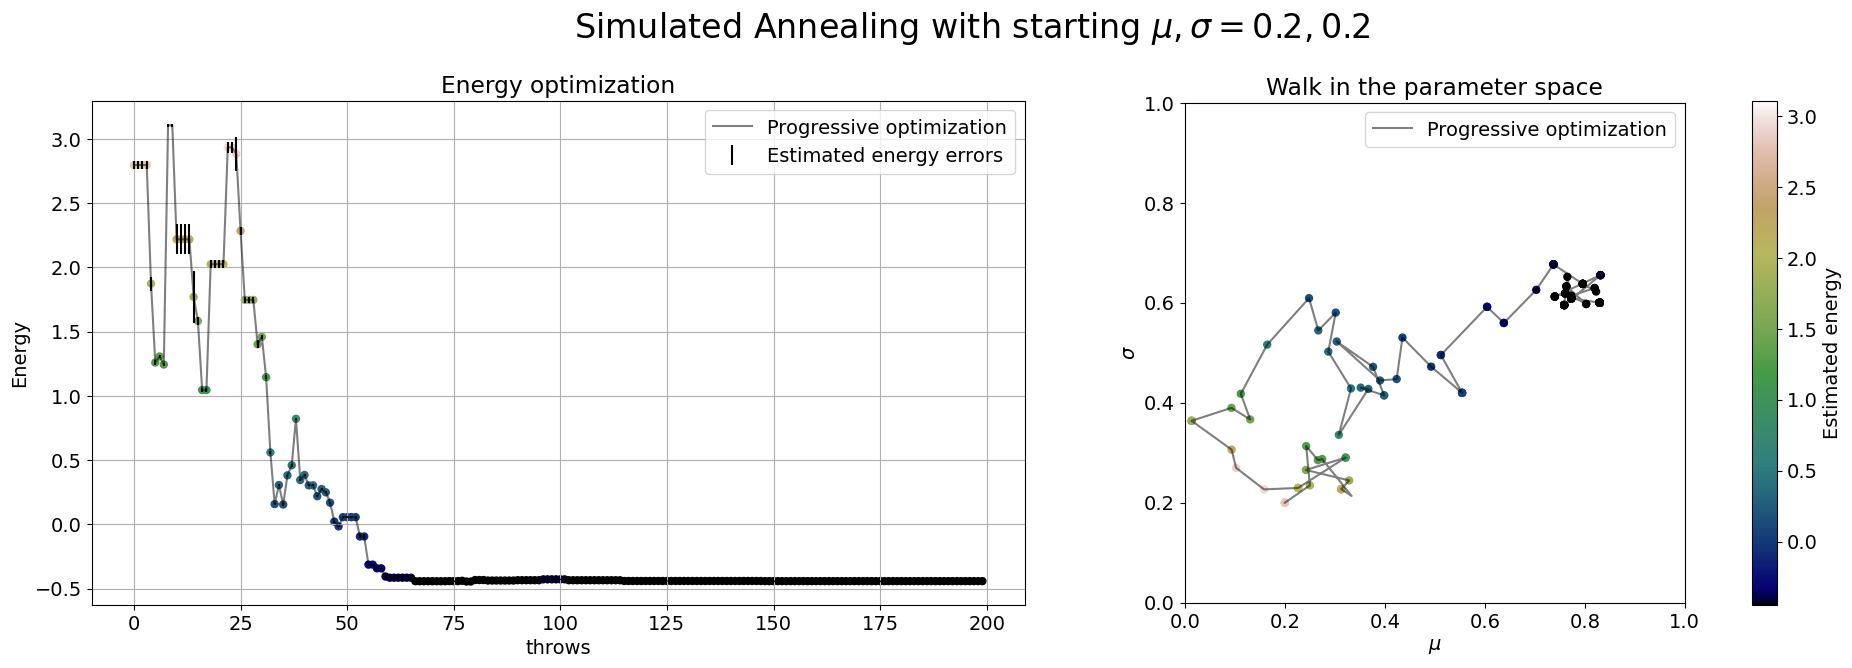

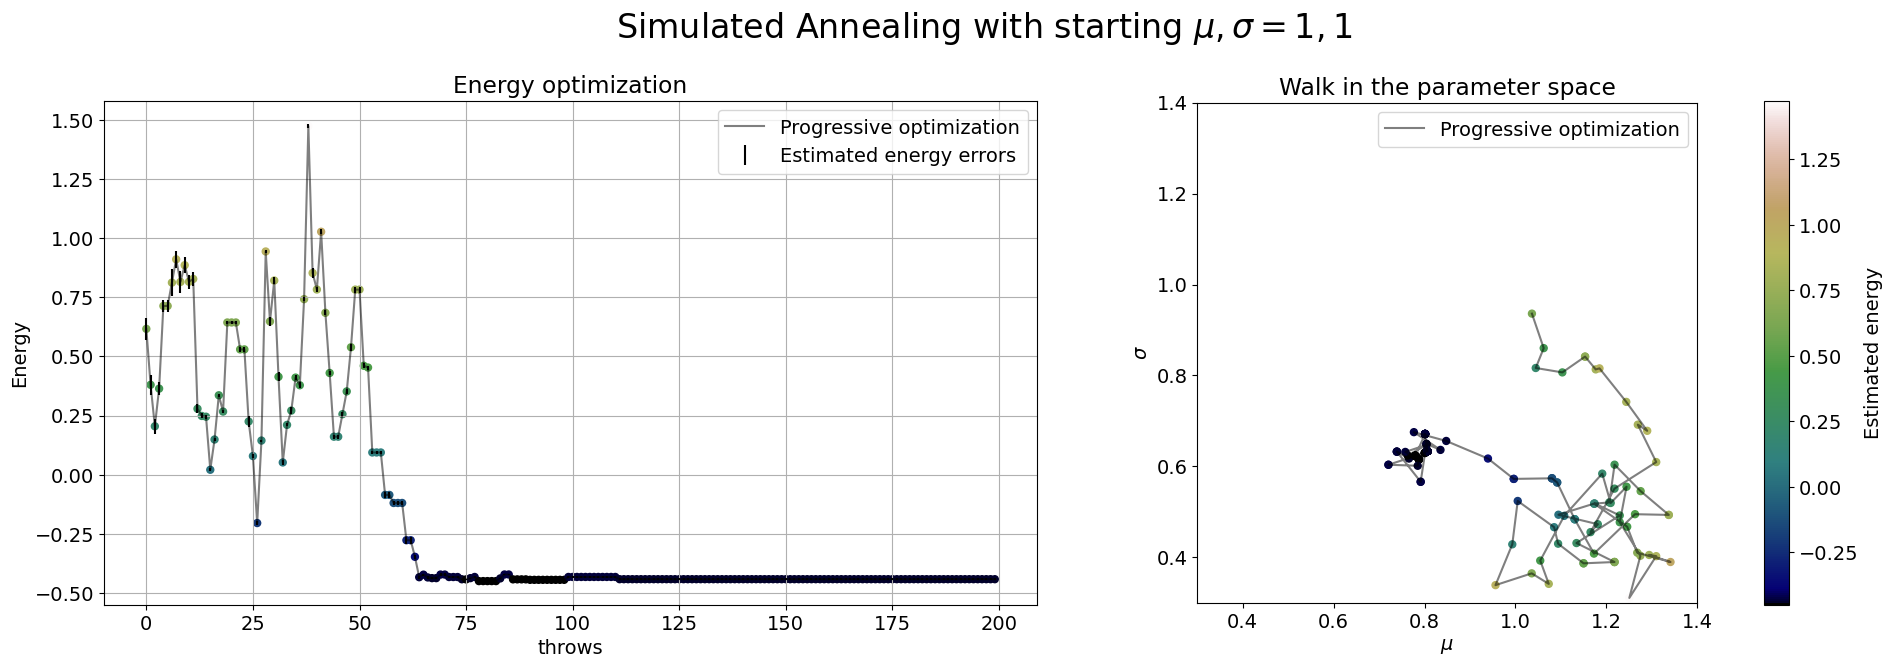

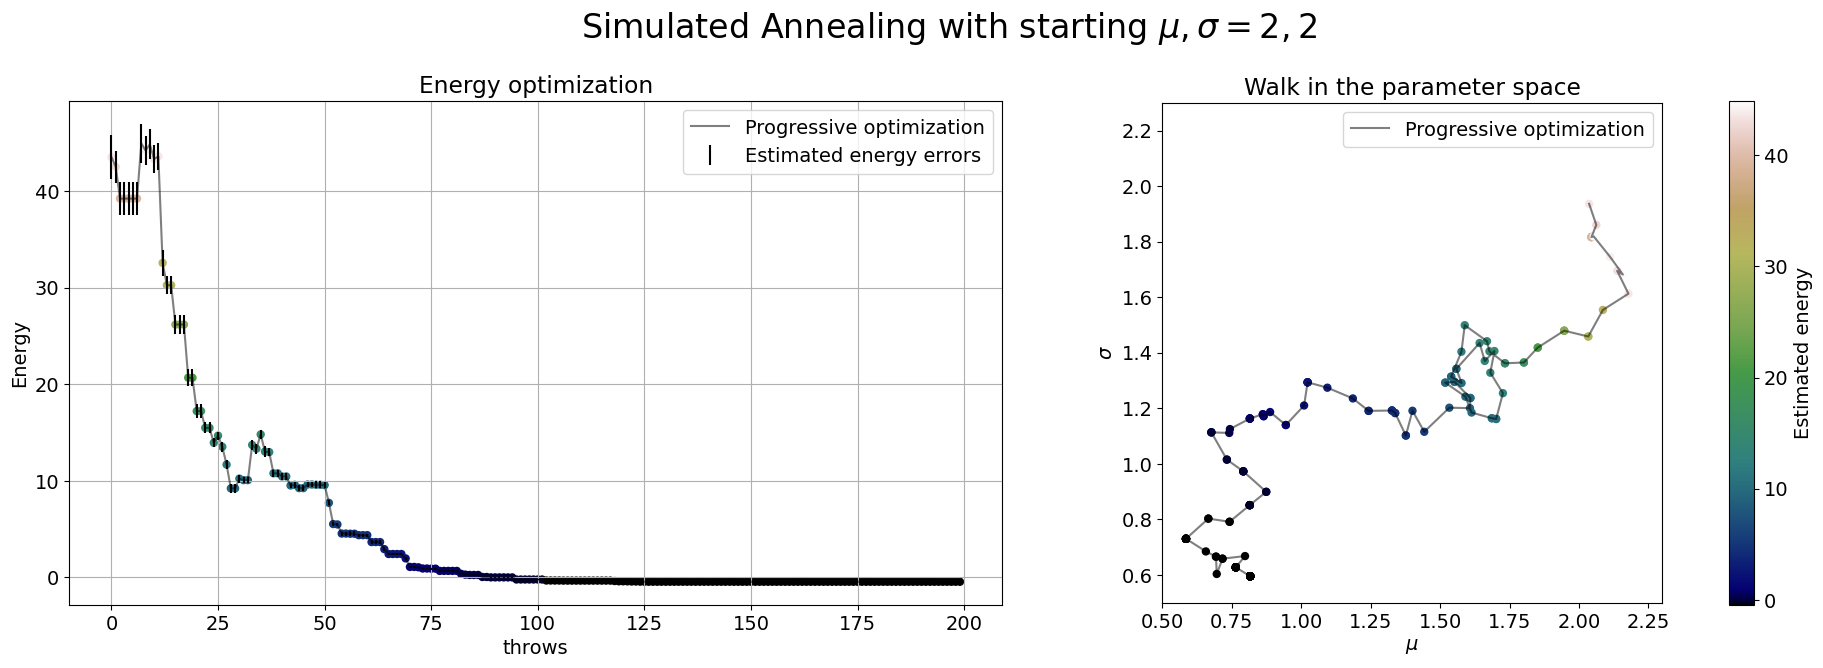

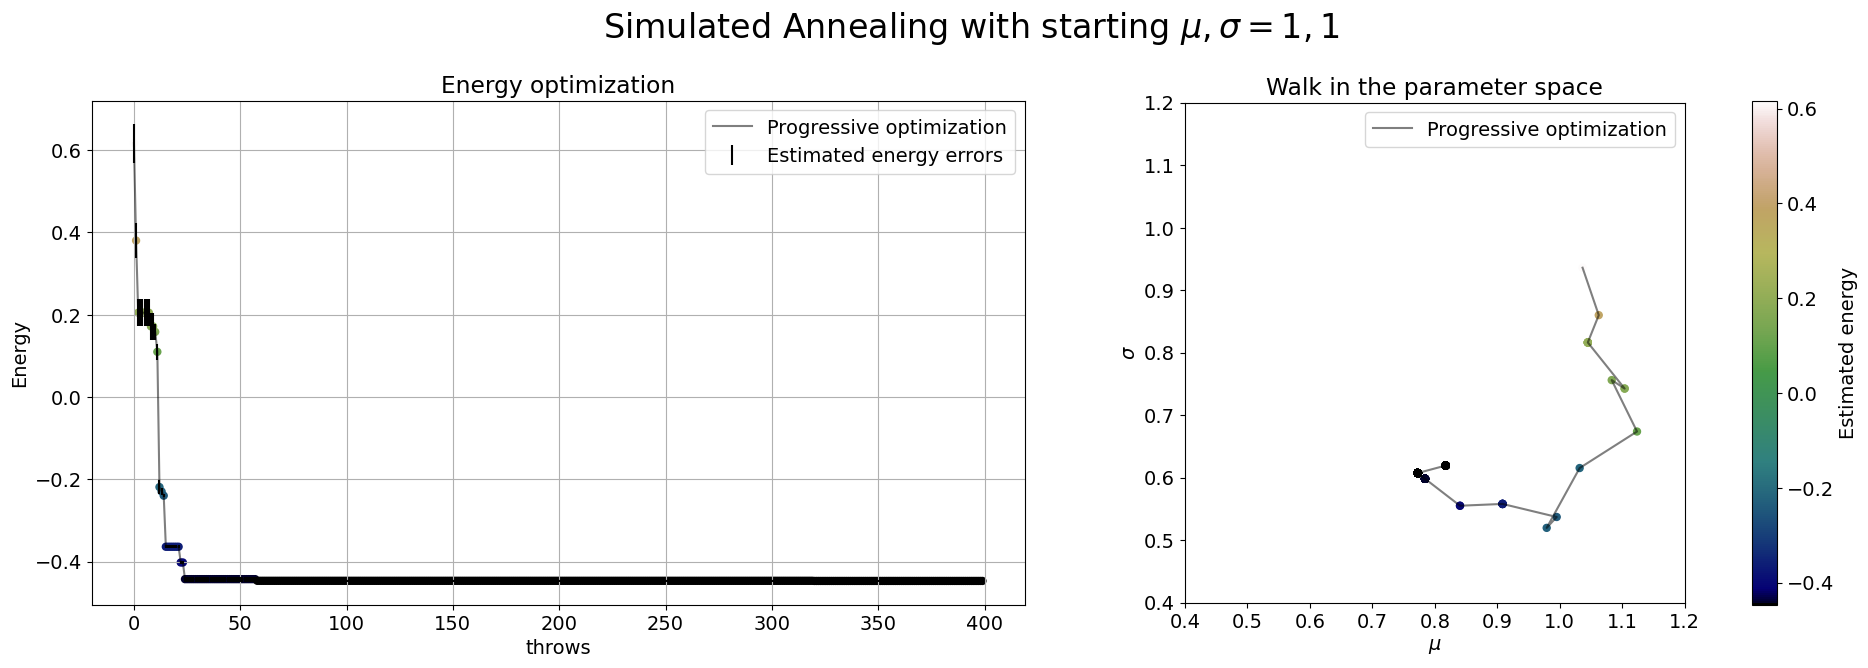

In [14]:
plotSimAnn("start0.2",[0,1,0,1], "0.2, 0.2")
plotSimAnn("start1,1",[0.3,1.4,0.3,1.4], "1, 1")
plotSimAnn("start2,2",[0.5,2.3,0.5,2.3], "2, 2")
plotSimAnn("bestSimul",[0.4,1.2,0.4,1.2], "1, 1", numberofdata=400,longsimul=1)

In [28]:
bestmu = 0.817378	      
bestsigma = 0.619481

In [17]:
from matplotlib.colors import ListedColormap

# Define the colors for the colormap to pass through
colors = [np.array([0, 0, 1, 1]),  # Blue
            np.array([0, 1, 0, 1]),  # Green
            np.array([1, 1, 0, 1]),  # Yellow
            np.array([1, 0, 0, 1])]  # Red

def new_cmap(colors, exponent=1.0, num_colors=1024):
    num_segments = len(colors) - 1
    segment_length = num_colors // num_segments

    cmap_colors = []
    for i in range(num_segments):
        start_color = colors[i]
        end_color = colors[i + 1]

        for j in range(segment_length):
            ratio = j / (segment_length - 1)
            interpolated_color = (end_color * ratio**exponent + start_color * (1 - ratio**exponent))
            cmap_colors.append(interpolated_color)

    return ListedColormap(cmap_colors)

def plotDescent(simulations):
    paths =["start0.2","start1,1","start2,2","bestSimul"]
    numberofdatas = [200,200,200,400]
    longsimuls = [0,0,0,1]
    # Create a colormap
    color_map = new_cmap(colors, exponent=0.16)

    # Plotting the data with error bars and color mapped based on the 'energy' variable
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    all_energies = []

    for i in range(simulations):
        mus, sigmas, energy, error = importDataSA(paths[i], numberofdatas[i], longsimuls[i])
        all_energies.extend(energy)

    # Normalize the colormap across all data points
    norm = plt.Normalize(min(all_energies),max(all_energies))
    sm = plt.cm.ScalarMappable(cmap=color_map, norm=norm)
    sm.set_array([])  # Dummy array needed for the colormap to work properly

    
    for i in range(simulations):
        mus, sigmas, energy, error = importDataSA(paths[i],numberofdatas[i],longsimuls[i])
        
        
        scatter1 = ax.scatter(mus,sigmas, c=energy, cmap=color_map, norm=norm,s=25)  # Use 'viridis' colormap, you can change it to any other colormap

        # Creating a line plot connecting the points
        ax.plot(mus,sigmas, color=colors[i], alpha=0.8, label=f'simuation {i+1}')  # Change color, alpha as needed



    # Adding labels, title, and legend
    ax.set_xlabel(f'$\mu$')
    ax.set_ylabel(r"$\sigma$")
    ax.set_title("Probing Energy Landscape")
    ax.legend()

    # Set equal aspect ratio for x and y axes
    ax.axis([0,2.3,0,2.3])
    ax.set_aspect('equal')
  
    # Adding a colorbar
    plt.colorbar(sm, label='Estimated energy', pad=0.1)

    # Display the plot
    plt.show()

It is interesting to plot the walks in the parameter space to inspect the algorithm's behaviour. Assigning a color to each estimated energy, we kind of get an estimated contour plot, which is of course more dense near the minimum.

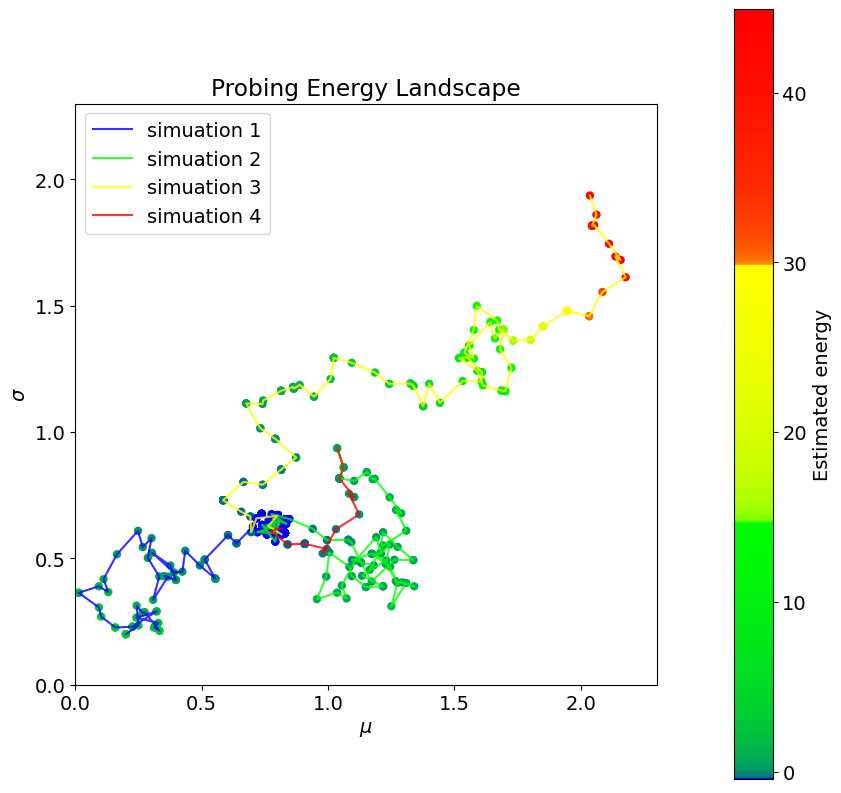

In [18]:
plotDescent(4)

In [91]:
data = np.loadtxt('start0.2/output_Annealing.txt', skiprows=1)
error = np.loadtxt('start0.2/output_Annealing_energy_errors.txt', skiprows=1)
energy = data[:,2]
betas = [10**(0+ 2*(i//50)) for i in range(200)]
energy = energy / betas
error = error[:-1]
mus = data[:,0]
sigmas = data[:,1]
error = repeat_values(energy,error)


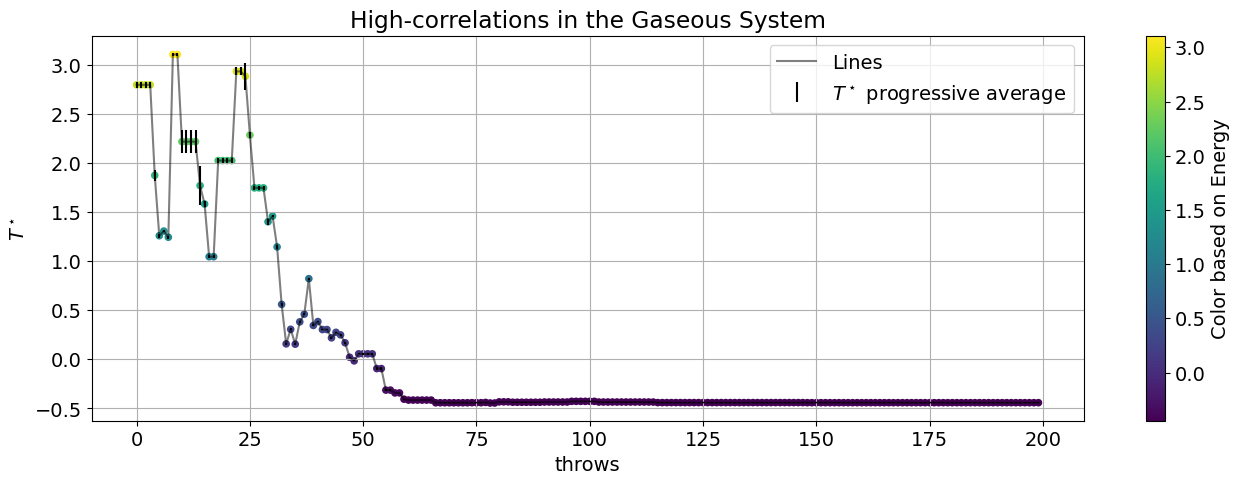

In [92]:
# Create a colormap
color_map = plt.cm.viridis

# Plotting the data with error bars and color mapped based on the 'energy' variable
fig, ax = plt.subplots(1, 1, figsize=(16, 5))
plt.errorbar(range(200), energy[:200], yerr=error[:200], fmt='o', ecolor="black", label=r"$T^\star$ progressive average", markersize=0)
scatter = ax.scatter(range(200), energy[:200], c=energy[:200], cmap=color_map, marker="o",s=20)

# Adding a colorbar
plt.colorbar(scatter, label='Color based on Energy')

# Creating a line plot connecting the points
plt.plot(range(200), energy[:200], color='black', alpha=0.5, label='Lines')  # Change color, alpha as needed

#plt.errorbar(range(200),energy[:200],yerr=error[:200], fmt='o', c=energy[:200], cmap='viridis',ecolor="orange", label =r"$T^\star$ progressive average")
plt.xlabel('throws')
plt.ylabel(r"$T^\star$")
plt.grid(True)
plt.title("High-correlations in the Gaseous System")
plt.legend()
plt.show()

### <span style="color:turquoise"> 08.2: Results </span>

We can now estimate the energy of our best trial wavefunction: we evaluate the progressive energy with $10e7$ steps and $100$ blocks.

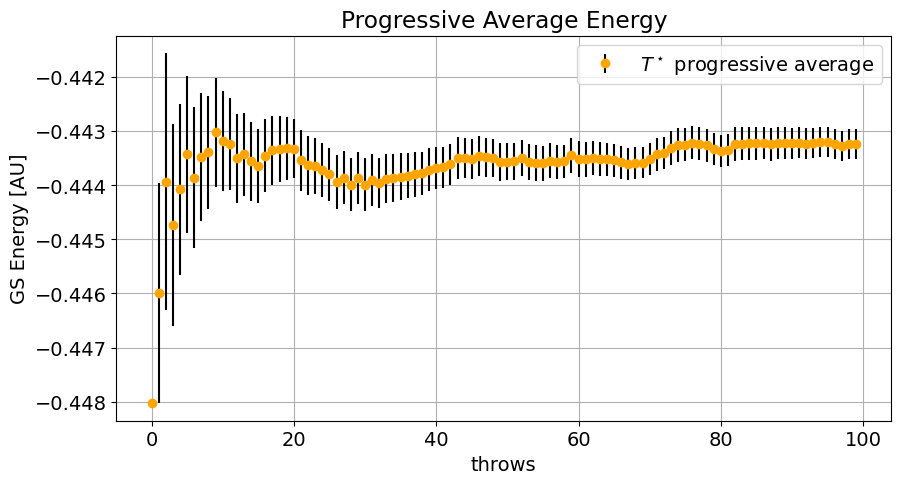

In [23]:
data = np.loadtxt('bestSimul/Energy_trial_wavefunction.txt', skiprows=1)

# Plotting the data with error bars and color mapped based on the 'energy' variable
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
plt.errorbar(range(100),data[:,0], yerr=data[:,1], fmt='o', color = "orange", ecolor="black", label=r"$T^\star$ progressive average")

#plt.errorbar(range(200),energy[:200],yerr=error[:200], fmt='o', c=energy[:200], cmap='viridis',ecolor="orange", label =r"$T^\star$ progressive average")
plt.xlabel('throws')
plt.ylabel(r"GS Energy [AU]")
plt.grid(True)
plt.title("Progressive Average Energy")
plt.legend()
plt.show()

We can also plot the sampled wavefunction squared and compare it to the analytical trial wavefunction found (check the sampling method) and the compare both of them to a numerical solution obtained by discretizing the problem and diagonalizing the hamiltonian.

The numerical solution from the diagonalization is an upper bound for the actual true energy: as the number of points in the discretization goes to infinity one recovers the true energy from above.

In [49]:
psi2 = np.loadtxt("psi2_sample.txt",skiprows=1)

Numerical Ground state energy:  -0.460465879692715


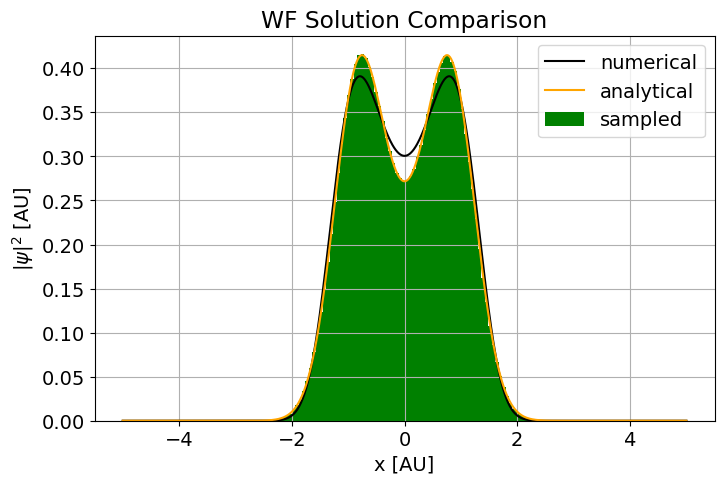

In [52]:
def Vpot(x):
    return (x**2 - 2.5)*x**2
    #return 0.5*x**2

hbar = 1
m = 1
a = 10
N = 1000 # number of iterations

# Step sizes
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0] # the step size
V = Vpot(x)

# The central differences method: f" = (f_1 - 2*f_0 + f_-1)/dx^2

CDiff = np.diag(np.ones(N-1),-1)-2*np.diag(np.ones(N),0)+np.diag(np.ones(N-1),1)
# np.diag(np.array,k) construct a "diagonal" matrix using the np.array
# The default is k=0. Use k>0 for diagonals above the main diagonal, 
# and k<0 for diagonals below the main diagonal

# Hamiltonian matrix
H = (-(hbar**2)*CDiff)/(2*m*dx**2) + np.diag(V)

# Compute eigenvectors and their eigenvalues
E,psi = np.linalg.eigh(H)

# Take the transpose & normalize
psi = np.transpose(psi)
psi = psi/np.sqrt(dx)

print("Numerical Ground state energy: ", E[0])

# Plot a few things
plt.figure(figsize=(8,5))
scale = 0.3
#plt.plot(x, scale*V, color="Black", label="Potential") # plot the potential
plt.plot(x,(psi[0])**2 ,color="black",label="numerical")
def analytical(x) :
    return ( np.exp(-(x-bestmu)**2/2/bestsigma**2) + np.exp(-(x+bestmu)**2/2/bestsigma**2) )**2

Norm = np.trapz(analytical(x),x)

plt.plot(x, analytical(x)/Norm, color = "orange", label="analytical")

plt.hist(psi2,bins=100,density=True, color="green", label="sampled")
plt.title("WF Solution Comparison")
plt.xlabel("x [AU]")
plt.ylabel(r"$|\psi|^2$ [AU]")
plt.grid(True)
#plt.xlim((-3,3))
#plt.ylim((-0.6,0.6))
plt.legend()
plt.show()